In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 701M/714M [00:08<00:00, 172MB/s]
100% 714M/714M [00:08<00:00, 89.8MB/s]


In [ ]:
! unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange





In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate



In [ ]:


import warnings
warnings.filterwarnings("ignore")


In [ ]:
import pandas as pd
from glob import glob

def create_dataframe(data_dir):
    mask_paths = glob(f'{data_dir}/*/*_mask*')
    image_paths = [path.replace('_mask', '') for path in mask_paths]

    return pd.DataFrame({'images_paths': image_paths, 'masks_paths': mask_paths})



In [ ]:


def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40

    # Use a single ImageDataGenerator for both images and masks
    data_gen = ImageDataGenerator(**aug_dict)

    # Image generator
    image_gen = data_gen.flow_from_dataframe(
        df,
        x_col='images_paths',
        class_mode=None,
        color_mode='rgb',
        target_size=img_size,
        batch_size=batch_size,
        save_to_dir=None,
        save_prefix='image',
        seed=1
    )

    # Mask generator
    mask_gen = data_gen.flow_from_dataframe(
        df,
        x_col='masks_paths',
        class_mode=None,
        color_mode='grayscale',
        target_size=img_size,
        batch_size=batch_size,
        save_to_dir=None,
        save_prefix='mask',
        seed=1
    )

    # Generator loop
    for (img, msk) in zip(image_gen, mask_gen):
        img = img / 255.0
        msk = msk / 255.0
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        yield (img, msk)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=(3, 3), padding="same"):
    """Helper function to apply Conv2D -> BatchNormalization -> Activation"""
    conv = Conv2D(filters, kernel_size, padding=padding)(inputs)
    bn = BatchNormalization(axis=3)(conv)
    act = Activation("relu")(bn)
    return act

def encoder_block(inputs, filters):
    """Helper function to apply two ConvBlocks followed by MaxPooling2D for the encoder part"""
    conv = conv_block(inputs, filters)
    conv = conv_block(conv, filters // 2)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def decoder_block(inputs, concat_tensor, filters):
    """Helper function to apply Conv2DTranspose -> concatenate -> two ConvBlocks for the decoder part"""
    up = Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding="same")(inputs)
    merged = concatenate([up, concat_tensor], axis=3)
    conv = conv_block(merged, filters)
    conv = conv_block(conv, filters // 2)
    return conv

def unet_optimized(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1, pool1 = encoder_block(inputs, 64)
    conv2, pool2 = encoder_block(pool1, 128)
    conv3, pool3 = encoder_block(pool2, 256)
    conv4, pool4 = encoder_block(pool3, 512)
    conv5, pool5 = encoder_block(pool4, 1024)
    # Bottleneck
    conv5 = conv_block(pool4, 2048)
    conv5 = conv_block(conv5, 1024)
    # Decoder

    conv6 = decoder_block(conv5, conv4, 512)
    conv7 = decoder_block(conv6, conv3, 256)
    conv8 = decoder_block(conv7, conv2, 128)
    conv9 = decoder_block(conv8, conv1, 64)

    # Output
    outputs = Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[outputs])

# Return the optimized model for inspection
unet_optimized()


In [ ]:
def intersection_and_union(y_true, y_pred):
    """Compute the intersection and the union of the true and predicted labels."""
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection, union

def dice_coef(y_true, y_pred, smooth=100):
    """
    Computes the Dice coefficient.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - smooth: Smoothing factor to prevent division by zero.

    Returns:
    - Dice coefficient.
    """
    intersection, union = intersection_and_union(y_true, y_pred)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    """
    Computes the Dice loss.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - smooth: Smoothing factor.

    Returns:
    - Dice loss.
    """
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    """
    Computes the Intersection over Union (IoU) coefficient.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - smooth: Smoothing factor to prevent division by zero.

    Returns:
    - IoU coefficient.
    """
    intersection, union = intersection_and_union(y_true, y_pred)
    return (intersection + smooth) / (union + smooth)




In [ ]:
import matplotlib.pyplot as plt
import cv2

def read_and_process_image(img_path, mask_path):
    """Reads and processes image and mask for visualization."""

    # Read image and convert it to RGB scale
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read mask
    mask = cv2.imread(mask_path)

    return image, mask

def show_images(images, masks):
    """
    Displays images and their corresponding masks side-by-side.

    Parameters:
    - images: List of paths to image files.
    - masks: List of paths to mask files.
    """

    plt.figure(figsize=(12, 12))

    for i in range(25):
        plt.subplot(5, 5, i+1)

        image, mask = read_and_process_image(images[i], masks[i])

        # Show image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
        plt.axis('off')

    plt.tight_layout()
    plt.show()




In [ ]:
def plot_metric(Epochs, tr_metric, val_metric, metric_name, subplot_num, best_epoch, best_val):
    """Helper function to plot a given metric."""
    plt.subplot(2, 2, subplot_num)
    plt.plot(Epochs, tr_metric, 'r', label=f'Training {metric_name}')
    plt.plot(Epochs, val_metric, 'g', label=f'Validation {metric_name}')
    plt.scatter(best_epoch, best_val, s=150, c='blue', label=f'best epoch= {best_epoch}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

def plot_training(hist):
    '''
    Plots training history of accuracy, IoU coefficient, Dice coefficient, and loss.
    Highlights the best epoch for each metric on the validation data.

    Parameters:
    - hist: Training history.
    '''

    # Define needed variables
    metrics = {
        'Accuracy': ('accuracy', 'val_accuracy', 1, False),
        'IoU': ('iou_coef', 'val_iou_coef', 2, False),
        'Dice': ('dice_coef', 'val_dice_coef', 3, False),
        'Loss': ('loss', 'val_loss', 4, True)
    }

    Epochs = list(range(1, len(hist.history['accuracy']) + 1))

    # Plot training history
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')

    for metric_name, (train_key, val_key, subplot_num, minimize) in metrics.items():
        tr_metric = hist.history[train_key]
        val_metric = hist.history[val_key]

        if minimize:  # For metrics like loss, we want to minimize it
            best_epoch = np.argmin(val_metric) + 1
        else:  # For other metrics, we want to maximize them
            best_epoch = np.argmax(val_metric) + 1

        best_val = val_metric[best_epoch - 1]

        plot_metric(Epochs, tr_metric, val_metric, metric_name, subplot_num, best_epoch, best_val)

    plt.tight_layout()
    plt.show()




In [ ]:
from sklearn.model_selection import train_test_split

def split_df(df, seed=None):
    """
    Splits the dataframe into training, validation, and test sets.

    Parameters:
    - df: input dataframe
    - seed: random seed for reproducibility

    Returns:
    - train_df, valid_df, test_df
    """
    # Split into train and (validation + test)
    train_df, interim_df = train_test_split(df, train_size=0.8, random_state=seed)

    # Split the (validation + test) into validation and test
    valid_df, test_df = train_test_split(interim_df, train_size=0.5, random_state=seed)

    return train_df, valid_df, test_df




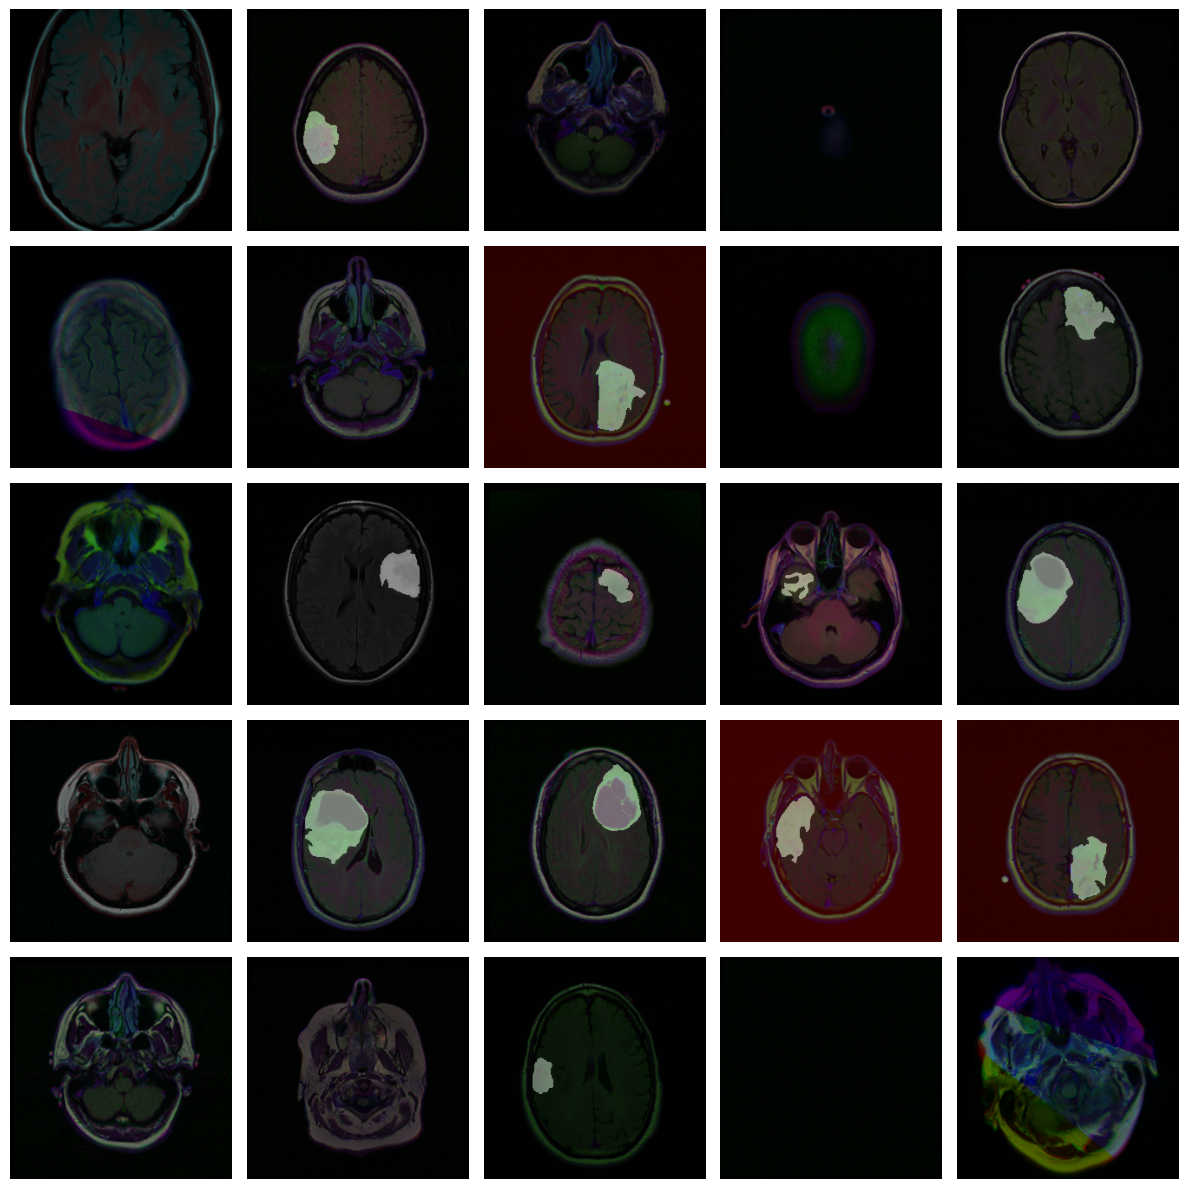

In [ ]:


DATA_DIR = './lgg-mri-segmentation/kaggle_3m'
TRAIN_AUGMENTATIONS = {
    'rotation_range': 0.2,
    'width_shift_range': 0.05,
    'height_shift_range': 0.05,
    'shear_range': 0.05,
    'zoom_range': 0.05,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}
NO_AUGMENTATIONS = {}

# Create dataframe and split
df = create_dataframe(DATA_DIR)
train_df, valid_df, test_df = split_df(df)

# Create data generators
train_gen = create_gens(train_df, aug_dict=TRAIN_AUGMENTATIONS)
valid_gen = create_gens(valid_df, aug_dict=NO_AUGMENTATIONS)
test_gen = create_gens(test_df, aug_dict=NO_AUGMENTATIONS)

# Show sample images from the training set
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))




In [ ]:
model = unet_optimized()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 256, 256, 64)         256       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_20 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_20

In [ ]:
 epochs = 100
batch_size = 40
callbacks = [ModelCheckpoint('unet.hdf5', verbose=0, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=len(valid_df) / batch_size)

Epoch 1/100
78/78 [==============================] - 142s 2s/step - loss: -0.2211 - accuracy: 0.9854 - iou_coef: 0.1110 - dice_coef: 0.2215 - val_loss: -0.0221 - val_accuracy: 0.9911 - val_iou_coef: 0.0112 - val_dice_coef: 0.0221
Epoch 2/100
78/78 [==============================] - 139s 2s/step - loss: -0.3847 - accuracy: 0.9905 - iou_coef: 0.1936 - dice_coef: 0.3864 - val_loss: -0.0677 - val_accuracy: 0.9659 - val_iou_coef: 0.0341 - val_dice_coef: 0.0681
Epoch 3/100
78/78 [==============================] - 142s 2s/step - loss: -0.6301 - accuracy: 0.9932 - iou_coef: 0.3147 - dice_coef: 0.6278 - val_loss: -0.2331 - val_accuracy: 0.9880 - val_iou_coef: 0.1169 - val_dice_coef: 0.2330
Epoch 4/100
78/78 [==============================] - 136s 2s/step - loss: -0.8638 - accuracy: 0.9944 - iou_coef: 0.4333 - dice_coef: 0.8643 - val_loss: -0.1677 - val_accuracy: 0.9686 - val_iou_coef: 0.0838 - val_dice_coef: 0.1668
Epoch 5/100
78/78 [==============================] - 142s 2s/step - loss: -1.068

In [ ]:
def evaluate_and_print(model, generator, steps, dataset_name):
    score = model.evaluate(generator, steps=steps, verbose=1)
    print(f"{dataset_name} Loss: {score[0]}")
    print(f"{dataset_name} Accuracy: {score[1]}")
    print(f"{dataset_name} IoU: {score[2]}")
    print(f"{dataset_name} Dice: {score[3]}")
    print('-' * 20)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

datasets = [("Train", train_gen), ("Valid", valid_gen), ("Test", test_gen)]

for dataset_name, generator in datasets:
    evaluate_and_print(model, generator, test_steps, dataset_name)


131/131 [==============================] - 115s 881ms/step - loss: -0.0218 - accuracy: 0.1019 - iou_coef: 0.0110 - dice_coef: 0.0219
Train Loss: -0.02184981293976307
Train Accuracy: 0.10191771388053894
Train IoU: 0.010950369760394096
Train Dice: 0.021859705448150635
--------------------
131/131 [==============================] - 21s 160ms/step - loss: -0.0233 - accuracy: 0.1026 - iou_coef: 0.0117 - dice_coef: 0.0233
Valid Loss: -0.023301340639591217
Valid Accuracy: 0.10260417312383652
Valid IoU: 0.011678188107907772
Valid Dice: 0.023314714431762695
--------------------
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 [==============================] - 24s 185ms/step - loss: -0.0232 - accuracy: 0.1030 - iou_coef: 0.0116 - dice_coef: 0.0232
Test Loss: -0.0232316255569458
Test Accuracy: 0.10297419130802155
Test IoU: 0.011635386385023594
Test Dice: 0.023229099810123444
--------------------


1/1 [==============================] - 1s 1s/step


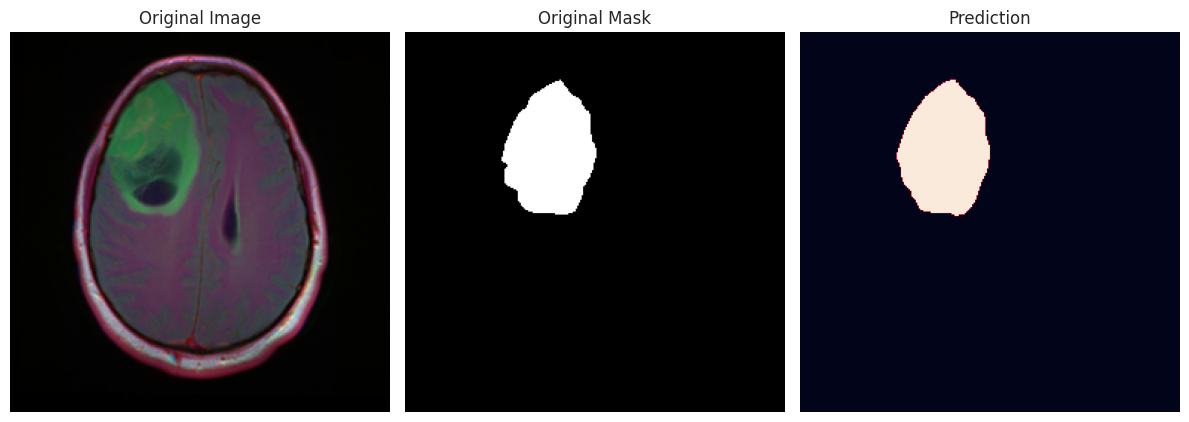

1/1 [==============================] - 0s 25ms/step


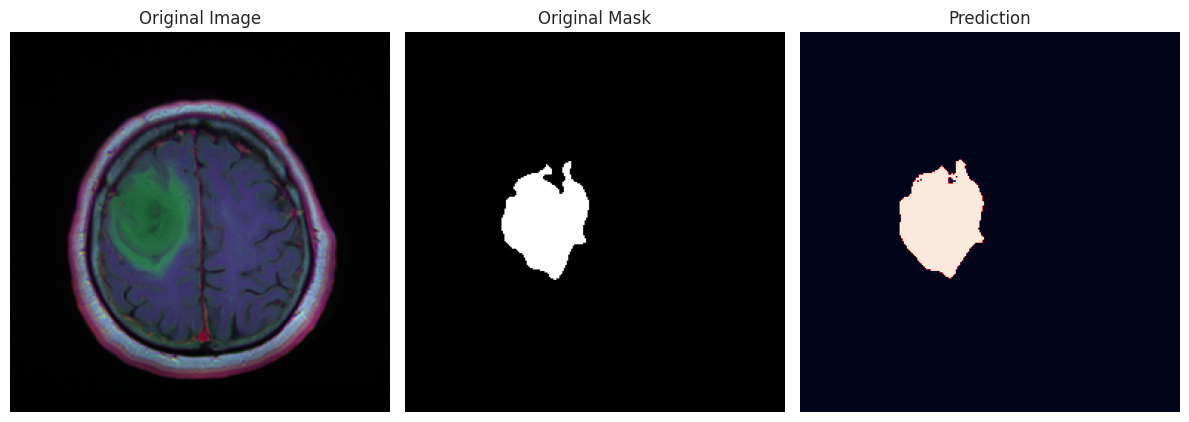

1/1 [==============================] - 0s 36ms/step


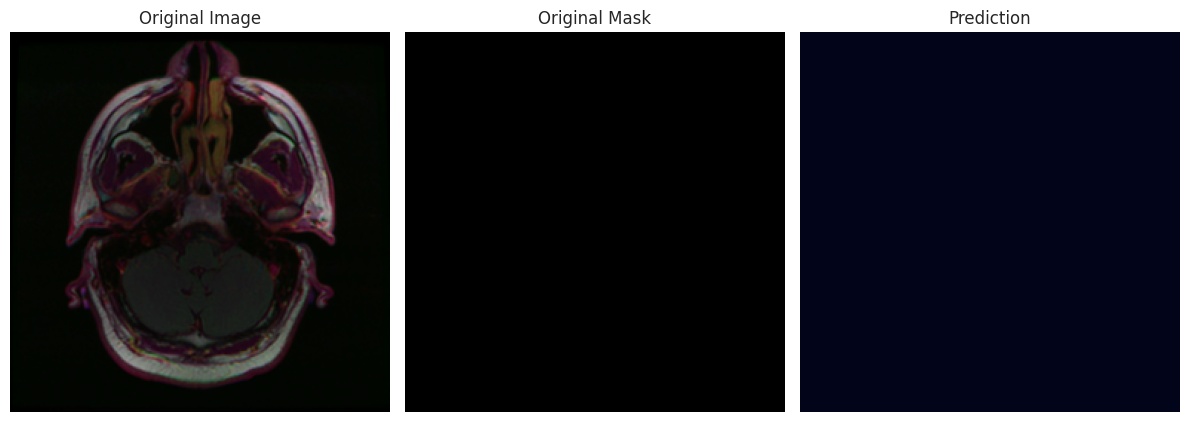

1/1 [==============================] - 0s 22ms/step


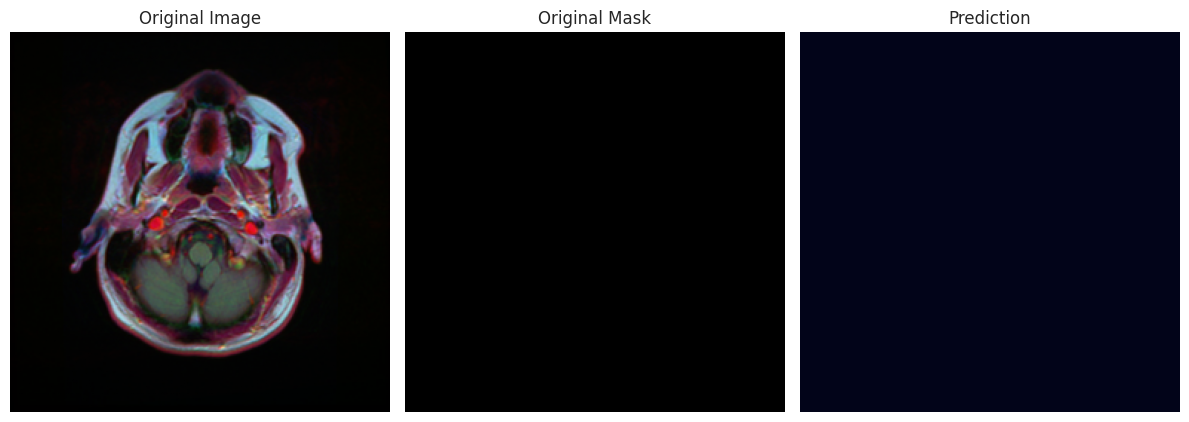

1/1 [==============================] - 0s 28ms/step


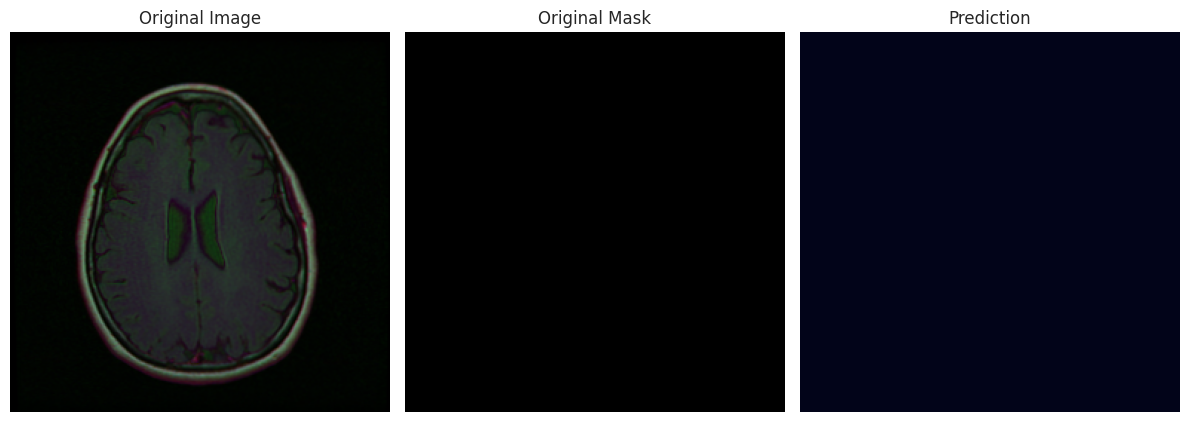

1/1 [==============================] - 0s 23ms/step


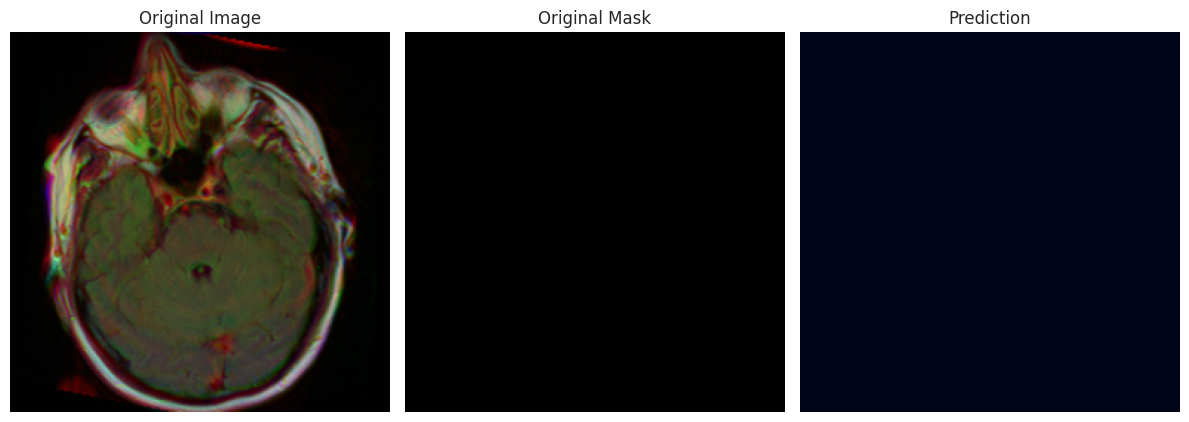

1/1 [==============================] - 0s 25ms/step


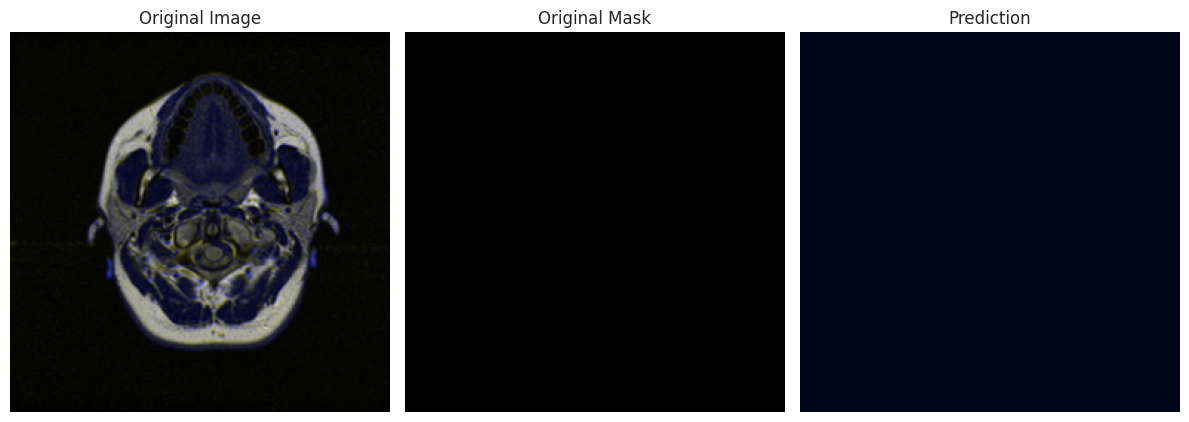

1/1 [==============================] - 0s 24ms/step


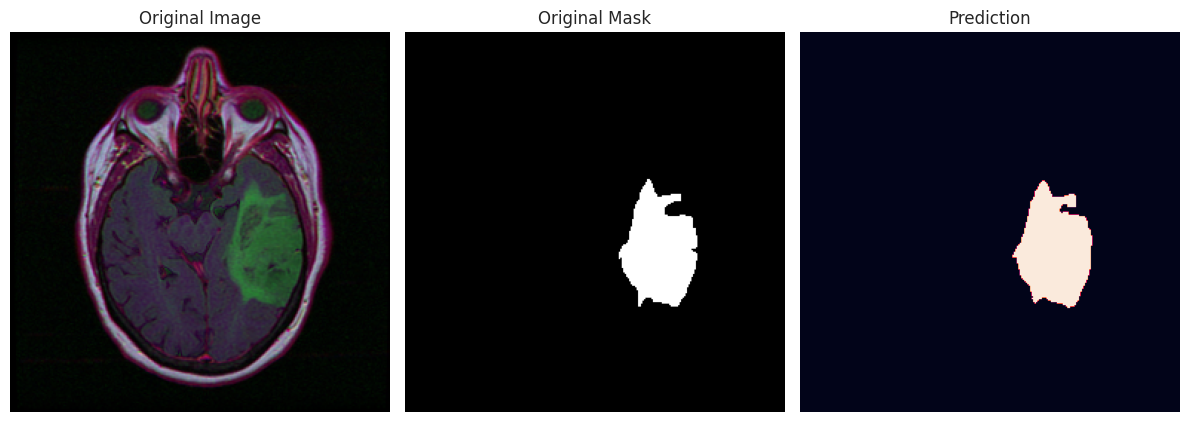

1/1 [==============================] - 0s 42ms/step


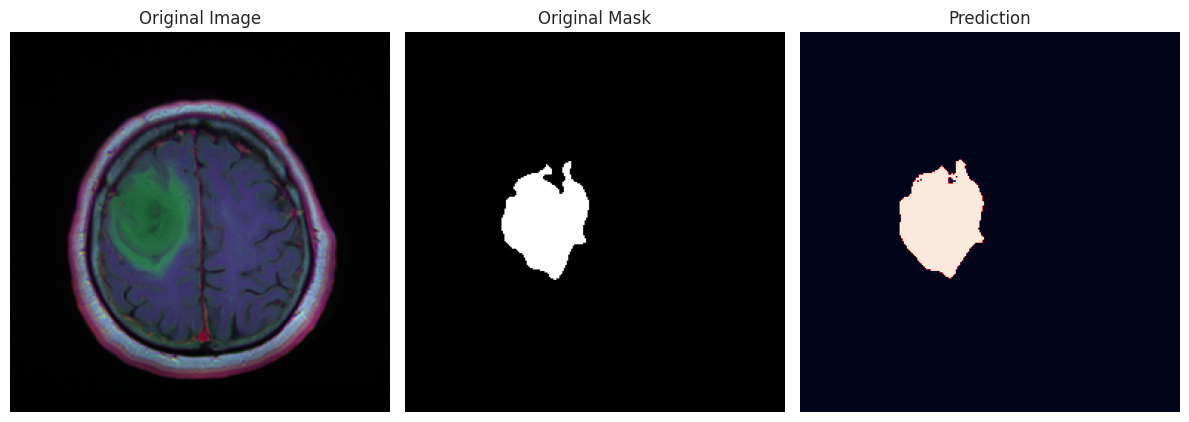

1/1 [==============================] - 0s 40ms/step


In [ ]:
def display_image(ax, img, title):
    ax.imshow(np.squeeze(img))
    ax.axis('off')
    ax.set_title(title)

n_samples = 20

for _ in range(n_samples):
    index = np.random.randint(1, len(test_df.index))
    image_row = test_df.iloc[index]

    img = cv2.imread(image_row['images_paths'])
    img = cv2.resize(img, (256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]

    predicted_img = model.predict(img)

    _, axs = plt.subplots(1, 3, figsize=(12, 12))

    display_image(axs[0], img, 'Original Image')
    display_image(axs[1], cv2.imread(image_row['masks_paths']), 'Original Mask')
    display_image(axs[2], predicted_img > 0.5, 'Prediction')

    plt.tight_layout()
    plt.show()
